## Setup & Imports

In [ ]:
# Core imports for data manipulation, visualization, and ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
from scipy.stats import uniform, randint

# Settings
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Visualization styling
plt.style.use('default')
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Helper function for boxplots with statistics
def plot_boxplots(data, features, title_suffix="", cols=4):
    """
    Creates boxplots with mean and median lines for multiple features.
    Use this to visualize distributions before/after processing.
    """
    n_features = len(features)

    # Calculate number of rows needed
    rows = (n_features + cols - 1) // cols  # Ceiling division

    # Create subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    # Flatten axes array for easy indexing
    if rows > 1:
        axes = axes.flatten()
    elif cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx, feature in enumerate(features):
        # Boxplot
        sns.boxplot(data=data, y=feature, ax=axes[idx])

        # Add mean and median lines
        mean_val = data[feature].mean()
        median_val = data[feature].median()

        axes[idx].axhline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[idx].axhline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

        axes[idx].set_title(f"{feature} {title_suffix}")
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    # Hide any unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

print("✅ Setup complete - All libraries imported and seed set")

✅ Setup complete - All libraries imported and seed set


##  Load Data & Verify BMI Integrity

In [ ]:
# Load the dataset
df = pd.read_csv('/content/DiaBD.csv')

# Verify BMI calculation integrity (critical medical data validation)
# BMI = weight (kg) / height² (m²)
df['bmi_check'] = df['weight'] / (df['height'] ** 2)

# Calculate difference and identify problematic records
bmi_diff = abs(df['bmi'] - df['bmi_check'])
problematic_bmi = bmi_diff > 0.1

print(f"🔍 BMI Integrity Check:")
print(f"   - Records with BMI difference > 0.1: {problematic_bmi.sum()}")
print(f"   - Maximum difference: {bmi_diff.max():.4f}")

# Replace incorrect BMI values with calculated ones
if problematic_bmi.any():
    df.loc[problematic_bmi, 'bmi'] = df.loc[problematic_bmi, 'bmi_check']
    print(f"   - ✅ Corrected {problematic_bmi.sum()} BMI values")

# Clean up temporary column
df.drop(columns=['bmi_check'], inplace=True)

print(f"\n📊 Dataset loaded successfully:")
print(f"   - Shape: {df.shape}")
print(f"   - Columns: {df.columns.tolist()}")
df.head()

🔍 BMI Integrity Check:
   - Records with BMI difference > 0.1: 1954
   - Maximum difference: 13.9448
   - ✅ Corrected 1954 BMI values

📊 Dataset loaded successfully:
   - Shape: (5288, 15)
   - Columns: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'glucose', 'height', 'weight', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'diabetic']


,age,gender,pulse_rate,systolic_bp,diastolic_bp,glucose,height,weight,bmi,family_diabetes,hypertensive,family_hypertension,cardiovascular_disease,stroke,diabetic
0,42,Female,66,110,73,5.88,1.65,70.2,25.750000,0,0,0,0,0,No
1,35,Female,60,125,68,5.71,1.47,42.5,19.580000,0,0,0,0,0,No
2,62,Female,57,127,74,6.85,1.52,47.0,20.342798,0,0,0,0,0,No
3,73,Male,55,193,112,6.28,1.63,57.4,21.604125,0,0,0,0,0,No
4,68,Female,71,150,81,5.71,1.42,36.0,17.790000,0,0,0,0,0,No


## Target Distribution Analysis

🎯 Target Variable Distribution:
   - No Diabetes (No): 4946 (93.5%)
   - Diabetes (Yes): 342 (6.5%)
   - Imbalance Ratio: 14.46:1


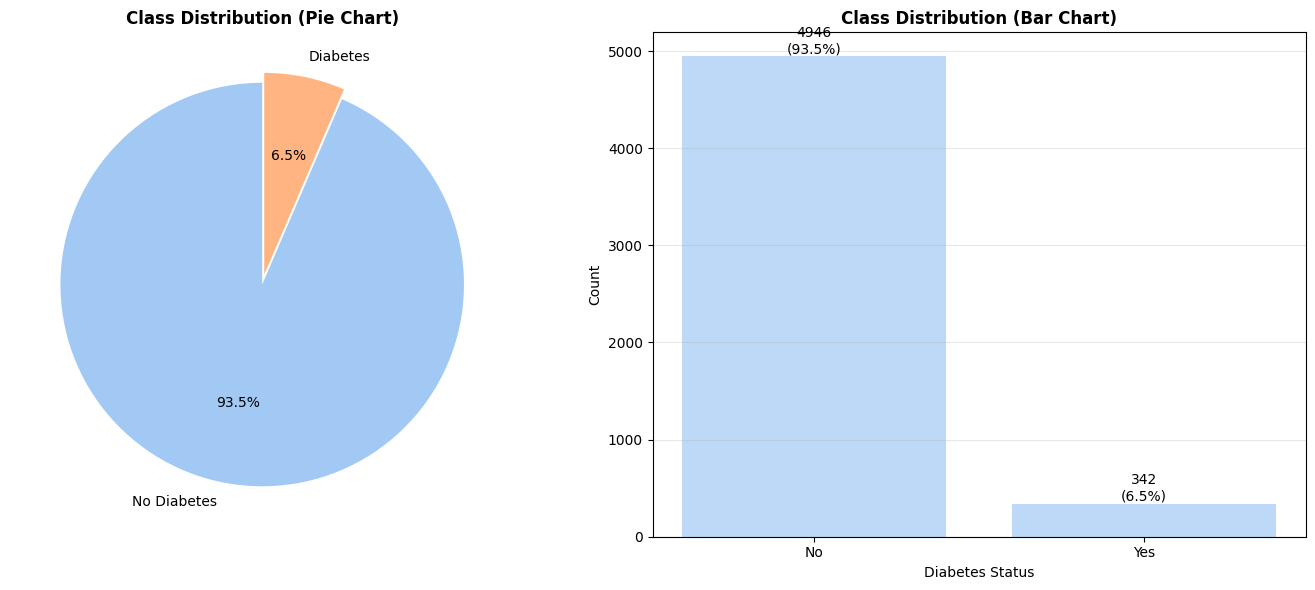

In [ ]:
# Target variable analysis
target_counts = df['diabetic'].value_counts()
target_percentages = df['diabetic'].value_counts(normalize=True) * 100

print("🎯 Target Variable Distribution:")
print(f"   - No Diabetes (No): {target_counts['No']} ({target_percentages['No']:.1f}%)")
print(f"   - Diabetes (Yes): {target_counts['Yes']} ({target_percentages['Yes']:.1f}%)")
print(f"   - Imbalance Ratio: {max(target_counts) / min(target_counts):.2f}:1")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
axes[0].pie(target_counts.values,
            labels=['No Diabetes', 'Diabetes'],
            autopct='%1.1f%%',
            startangle=90,
            explode=(0, 0.05))
axes[0].set_title('Class Distribution (Pie Chart)', fontweight='bold')

# Bar chart
bars = axes[1].bar(target_counts.index, target_counts.values, alpha=0.7)
axes[1].set_title('Class Distribution (Bar Chart)', fontweight='bold')
axes[1].set_xlabel('Diabetes Status')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({height/len(df)*100:.1f}%)',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Missing Values & Duplicates

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("🔍 Missing Values Check:")
if missing_values.any():
    print(missing_values[missing_values > 0])
else:
    print("   ✅ No missing values found (great for medical data)")

# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"\n🔄 Duplicates Check:")
print(f"   - Duplicate rows: {duplicate_count}")
if duplicate_count > 0:
    print("   ⚠️  Consider investigating duplicates in clinical context")

🔍 Missing Values Check:
   ✅ No missing values found (great for medical data)

🔄 Duplicates Check:
   - Duplicate rows: 0


## Original Feature Outlier Detection

📈 Original Feature Outlier Counts (IQR Method):
   - age            :    0 outliers ( 0.00%)
   - pulse_rate     :   96 outliers ( 1.82%)
   - systolic_bp    :  113 outliers ( 2.14%)
   - diastolic_bp   :   54 outliers ( 1.02%)
   - glucose        :  400 outliers ( 7.56%)
   - height         :  193 outliers ( 3.65%)
   - weight         :   79 outliers ( 1.49%)
   - bmi            :  136 outliers ( 2.57%)

📊 Original Feature Boxplots:


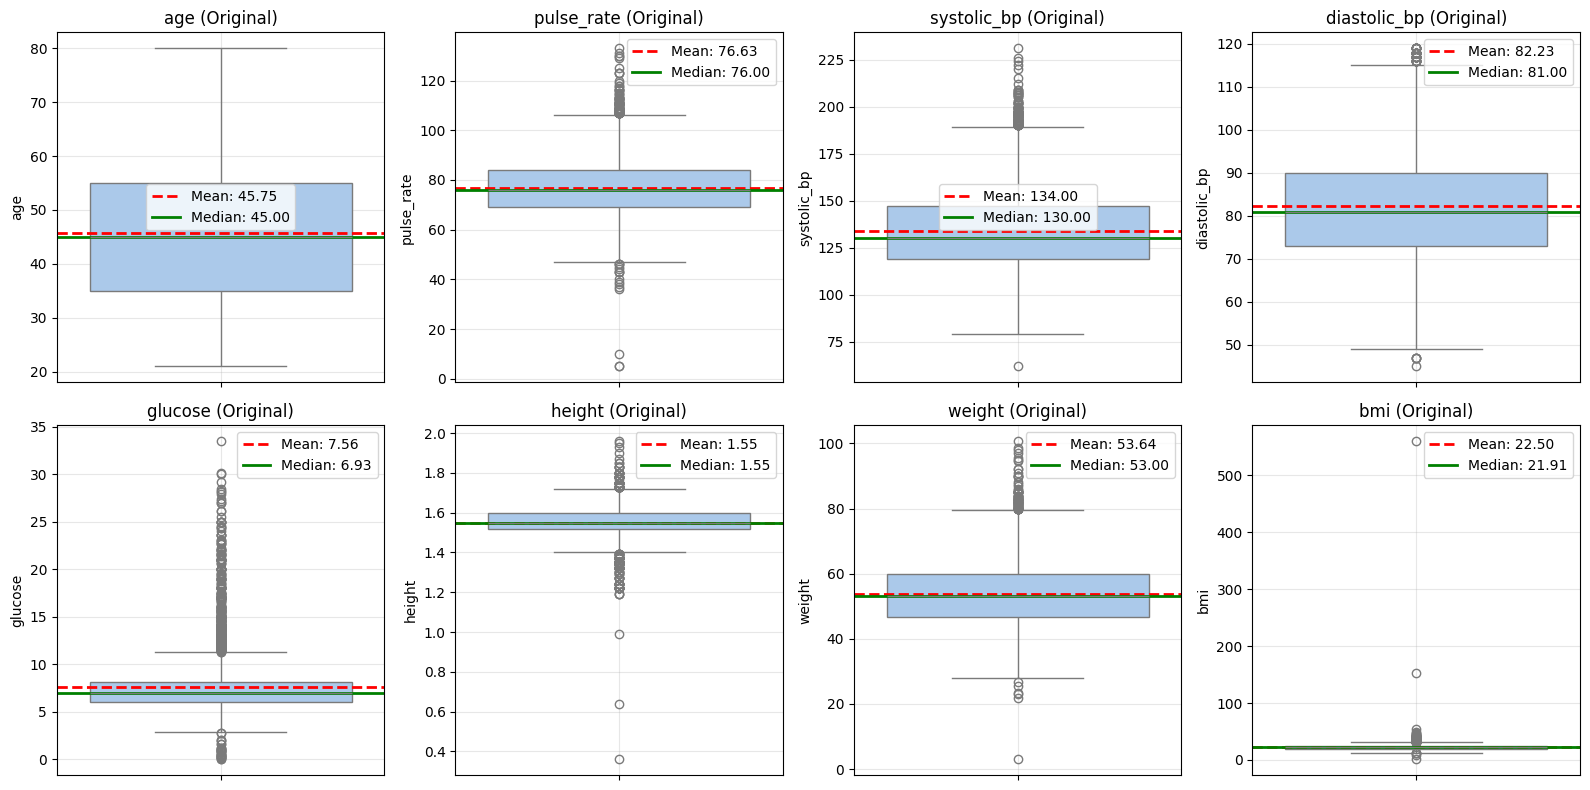

In [ ]:
# Define numerical features for analysis
numerical_features = ['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp',
                      'glucose', 'height', 'weight', 'bmi']

# Function to count outliers using IQR method
def count_outliers_iqr(data, features):
    """Counts outliers without removing them - just for awareness"""
    outlier_info = {}

    for feature in features:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        outlier_info[feature] = len(outliers)

    return outlier_info

# Count outliers in original data
print("📈 Original Feature Outlier Counts (IQR Method):")
outlier_counts = count_outliers_iqr(df, numerical_features)
for feature, count in outlier_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   - {feature:15s}: {count:4d} outliers ({percentage:5.2f}%)")

# Visualize original distributions
print("\n📊 Original Feature Boxplots:")
plot_boxplots(df, numerical_features, "(Original)")

## Train-Test Split

In [ ]:
# Separate features and target
X = df.drop(columns=['diabetic'])
y = df['diabetic']

# CRITICAL: Split BEFORE any preprocessing to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y  # Preserve class distribution
)

print("✅ Train-Test Split Complete:")
print(f"   - Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"   - Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Verify class distribution preservation
print("\n📊 Class Distribution After Split:")
for name, y_set in [("Train", y_train), ("Test", y_test)]:
    counts = y_set.value_counts()
    percentages = y_set.value_counts(normalize=True) * 100
    print(f"   - {name:5s}: No={counts.get('No',0)} ({percentages.get('No',0):.1f}%), Yes={counts.get('Yes',0)} ({percentages.get('Yes',0):.1f}%)")

✅ Train-Test Split Complete:
   - Training set: 4230 samples (80.0%)
   - Test set: 1058 samples (20.0%)

📊 Class Distribution After Split:
   - Train: No=3956 (93.5%), Yes=274 (6.5%)
   - Test : No=990 (93.6%), Yes=68 (6.4%)


## Target Encoding

In [ ]:
# Encode target: Yes→1, No→0
target_mapping = {'Yes': 1, 'No': 0}

y_train_encoded = y_train.map(target_mapping)
y_test_encoded = y_test.map(target_mapping)

print("🎯 Target Encoding Applied:")
print(f"   - Mapping: {target_mapping}")
print(f"   - y_train: {y_train_encoded.value_counts().to_dict()}")
print(f"   - y_test: {y_test_encoded.value_counts().to_dict()}")

# Verify no missing values after mapping
assert not y_train_encoded.isnull().any(), "Target encoding failed for training set!"
assert not y_test_encoded.isnull().any(), "Target encoding failed for test set!"
print("   ✅ Encoding verified successfully")

🎯 Target Encoding Applied:
   - Mapping: {'Yes': 1, 'No': 0}
   - y_train: {0: 3956, 1: 274}
   - y_test: {0: 990, 1: 68}
   ✅ Encoding verified successfully


## Critical Medical Filters

In [ ]:
# Define physiologically impossible ranges (clinical validity filters)
medical_filters = {
    'height': (1.0, 2.2),      # meters
    'weight': (30, 200),       # kg
    'pulse_rate': (40, 180),   # bpm
    'bmi': (10, 60),           # kg/m²
    'glucose': (2, 20)         # mmol/L
}

print("🔬 Applying Medical Filters (TRAINING SET ONLY):")
print("   - This prevents data leakage and removes physiologically impossible values")

original_train_size = len(X_train)

# Apply filters sequentially
for feature, (min_val, max_val) in medical_filters.items():
    before_filter = len(X_train)
    mask = (X_train[feature] >= min_val) & (X_train[feature] <= max_val)
    X_train = X_train[mask]
    y_train_encoded = y_train_encoded[mask]
    removed = before_filter - len(X_train)
    print(f"   - {feature:15s}: kept {len(X_train):5d} | removed {removed:3d} (outside {min_val}-{max_val})")

rows_removed = original_train_size - len(X_train)
print(f"\n📊 Filter Summary:")
print(f"   - Original rows: {original_train_size}")
print(f"   - Rows removed: {rows_removed} ({rows_removed/original_train_size*100:.1f}%)")
print(f"   - Final training size: {X_train.shape}")

🔬 Applying Medical Filters (TRAINING SET ONLY):
   - This prevents data leakage and removes physiologically impossible values
   - height         : kept  4228 | removed   2 (outside 1.0-2.2)
   - weight         : kept  4223 | removed   5 (outside 30-200)
   - pulse_rate     : kept  4217 | removed   6 (outside 40-180)
   - bmi            : kept  4217 | removed   0 (outside 10-60)
   - glucose        : kept  4147 | removed  70 (outside 2-20)

📊 Filter Summary:
   - Original rows: 4230
   - Rows removed: 83 (2.0%)
   - Final training size: (4147, 14)


## Winsorization

📊 Calculating Winsorization Bounds (1st-99th Percentile):
   - systolic_bp    : [  95.00,  196.00]
   - diastolic_bp   : [  56.00,  115.54]
   - pulse_rate     : [  51.00,  109.00]
   - glucose        : [   4.04,   17.06]
   - bmi            : [  14.79,   34.40]
   - height         : [   1.35,    1.73]
   - weight         : [  33.70,   80.91]

📈 Training Data Boxplots - BEFORE Winsorization:


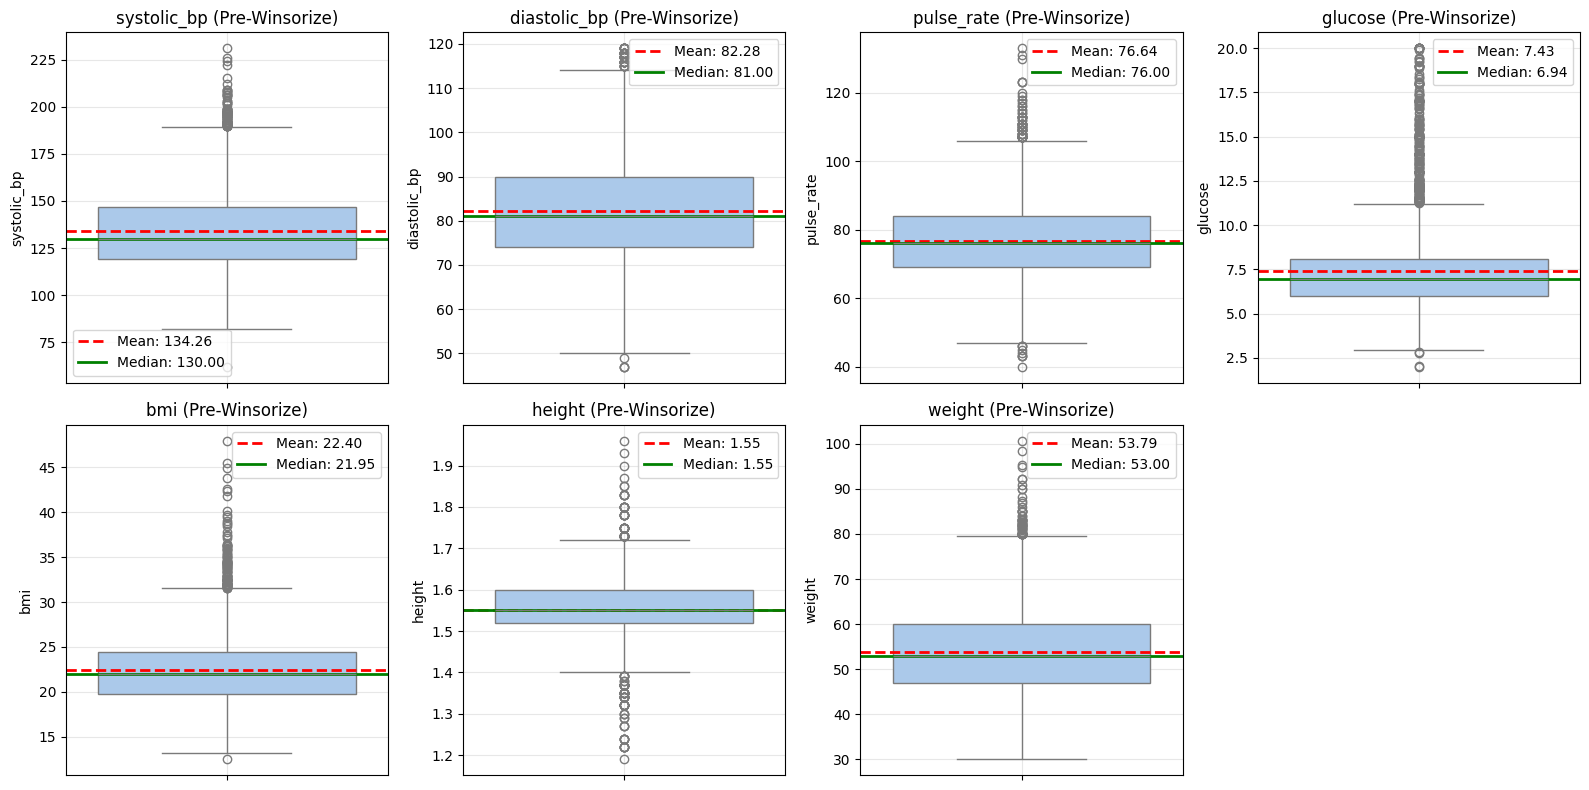


✂️ Applying Winsorization to Train and Test Sets...

📊 Training Data Boxplots - AFTER Winsorization:


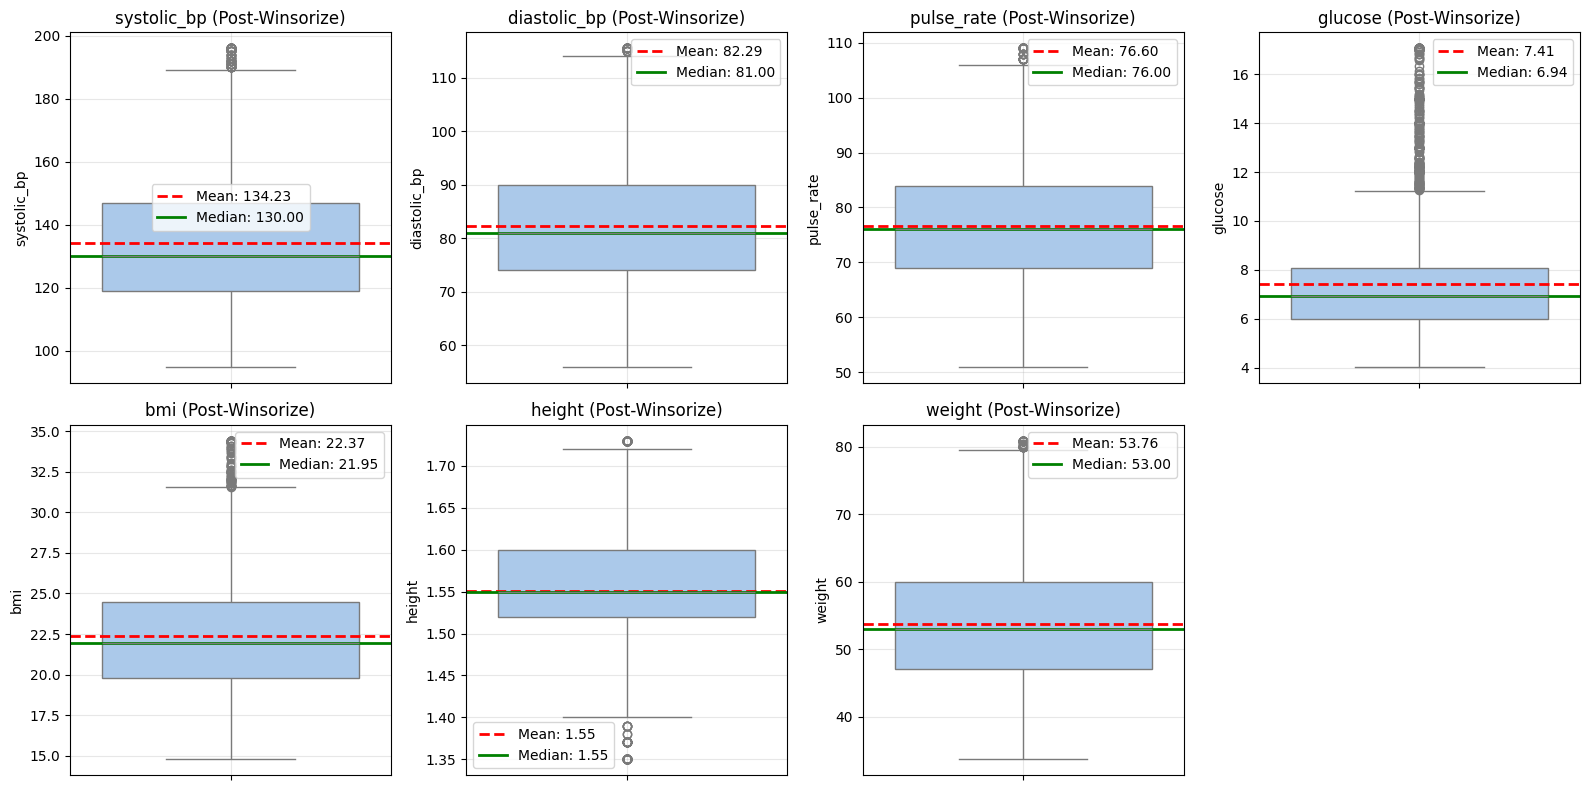


✅ Winsorization complete - Outliers clipped using training data bounds only


In [ ]:
# Features to winsorize (clip extreme values)
winsorize_features = ['systolic_bp', 'diastolic_bp', 'pulse_rate',
                      'glucose', 'bmi', 'height', 'weight']

# CRITICAL: Calculate percentiles ONLY from training data
percentiles = {}
print("📊 Calculating Winsorization Bounds (1st-99th Percentile):")
for feature in winsorize_features:
    lower = X_train[feature].quantile(0.01)
    upper = X_train[feature].quantile(0.99)
    percentiles[feature] = (lower, upper)
    print(f"   - {feature:15s}: [{lower:7.2f}, {upper:7.2f}]")

# Visualize BEFORE winsorization
print("\n📈 Training Data Boxplots - BEFORE Winsorization:")
plot_boxplots(X_train, winsorize_features, "(Pre-Winsorize)")

# Apply winsorization to BOTH train and test using training bounds
print("\n✂️ Applying Winsorization to Train and Test Sets...")
for feature in winsorize_features:
    lower, upper = percentiles[feature]
    X_train[feature] = X_train[feature].clip(lower=lower, upper=upper)
    X_test[feature] = X_test[feature].clip(lower=lower, upper=upper)

# Visualize AFTER winsorization
print("\n📊 Training Data Boxplots - AFTER Winsorization:")
plot_boxplots(X_train, winsorize_features, "(Post-Winsorize)")

print("\n✅ Winsorization complete - Outliers clipped using training data bounds only")

## Clinical Feature Engineering

In [ ]:
# Calculate clinically meaningful features

# 1. Pulse Pressure (strong cardiovascular predictor)
X_train['pulse_pressure'] = X_train['systolic_bp'] - X_train['diastolic_bp']
X_test['pulse_pressure'] = X_test['systolic_bp'] - X_test['diastolic_bp']

# 2. Hypertension Flag (clinical threshold)
X_train['hypertension_flag'] = ((X_train['systolic_bp'] >= 140) |
                                (X_train['diastolic_bp'] >= 90)).astype(int)
X_test['hypertension_flag'] = ((X_test['systolic_bp'] >= 140) |
                               (X_test['diastolic_bp'] >= 90)).astype(int)

# 3. Obesity Flag (WHO classification)
X_train['obesity_flag'] = (X_train['bmi'] >= 30).astype(int)
X_test['obesity_flag'] = (X_test['bmi'] >= 30).astype(int)

print("🔬 Clinical Features Engineered:")
print("   - pulse_pressure: systolic_bp - diastolic_bp (cardiovascular risk)")
print("   - hypertension_flag: 1 if sbp≥140 or dbp≥90")
print("   - obesity_flag: 1 if bmi≥30")

print(f"\n📊 New shape after feature engineering:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")

🔬 Clinical Features Engineered:
   - pulse_pressure: systolic_bp - diastolic_bp (cardiovascular risk)
   - hypertension_flag: 1 if sbp≥140 or dbp≥90
   - obesity_flag: 1 if bmi≥30

📊 New shape after feature engineering:
   - X_train: (4147, 17)
   - X_test: (1058, 17)


## Log Transform & Multicollinearity Cleanup


In [ ]:
# Log transform glucose to reduce skewness
X_train['glucose_log'] = np.log1p(X_train['glucose'])
X_test['glucose_log'] = np.log1p(X_test['glucose'])

# Identify multicollinear features to drop
features_to_drop = ['glucose', 'height', 'weight']

X_train.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)

print("🧹 Multicollinearity Cleanup:")
print(f"   - Dropped: {features_to_drop}")
print(f"   - Kept glucose_log (log-transformed, less skewed)")
print(f"   - Kept BMI (captures height/weight relationship)")
print(f"\n📊 Final feature counts:")
print(f"   - X_train: {X_train.shape[1]} features")
print(f"   - X_test: {X_test.shape[1]} features")

🧹 Multicollinearity Cleanup:
   - Dropped: ['glucose', 'height', 'weight']
   - Kept glucose_log (log-transformed, less skewed)
   - Kept BMI (captures height/weight relationship)

📊 Final feature counts:
   - X_train: 15 features
   - X_test: 15 features


## BMI Categories & Gender Encoding

In [ ]:
# Create BMI categories (WHO standards)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

X_train['bmi_category'] = X_train['bmi'].apply(categorize_bmi)
X_test['bmi_category'] = X_test['bmi'].apply(categorize_bmi)

# One-hot encode BMI categories
bmi_dummies_train = pd.get_dummies(X_train['bmi_category'], prefix='bmi')
bmi_dummies_test = pd.get_dummies(X_test['bmi_category'], prefix='bmi')

# Align columns (ensure both have same dummy columns)
all_bmi_cols = set(bmi_dummies_train.columns) | set(bmi_dummies_test.columns)
for col in all_bmi_cols:
    if col not in bmi_dummies_train.columns:
        bmi_dummies_train[col] = 0
    if col not in bmi_dummies_test.columns:
        bmi_dummies_test[col] = 0

bmi_dummies_train = bmi_dummies_train[sorted(bmi_dummies_train.columns)]
bmi_dummies_test = bmi_dummies_test[sorted(bmi_dummies_test.columns)]

# Add dummies to datasets and drop original category column
X_train = pd.concat([X_train.drop(columns=['bmi_category']), bmi_dummies_train], axis=1)
X_test = pd.concat([X_test.drop(columns=['bmi_category']), bmi_dummies_test], axis=1)

# Encode gender: Female→0, Male→1
gender_mapping = {'Female': 0, 'Male': 1}
X_train['gender'] = X_train['gender'].map(gender_mapping)
X_test['gender'] = X_test['gender'].map(gender_mapping)

print("🏷️ Encoding Complete:")
print(f"   - BMI categories one-hot encoded: {list(bmi_dummies_train.columns)}")
print(f"   - Gender mapped: {gender_mapping}")
print(f"\n📊 Final dataset shapes:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_test: {X_test.shape}")
print(f"   - Features: {X_train.columns.tolist()}")

🏷️ Encoding Complete:
   - BMI categories one-hot encoded: ['bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']
   - Gender mapped: {'Female': 0, 'Male': 1}

📊 Final dataset shapes:
   - X_train: (4147, 19)
   - X_test: (1058, 19)
   - Features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'obesity_flag', 'glucose_log', 'bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']


In [ ]:
# Convert binary/categorical columns to proper data types (SAFER APPROACH)
binary_columns = [
    'gender', 'family_diabetes', 'hypertensive', 'family_hypertension',
    'cardiovascular_disease', 'stroke', 'hypertension_flag', 'obesity_flag'
]

print("🔄 Converting binary columns to proper types:")
for col in binary_columns:
    if col in X_train.columns:
        # First check for any unexpected values
        unique_vals = X_train[col].unique()
        print(f"   - {col}: unique values {sorted(unique_vals)}")

        # Convert to int first to ensure no float/NaN issues, then to category
        X_train[col] = X_train[col].astype(int).astype('category')
        X_test[col] = X_test[col].astype(int).astype('category')
        print(f"     Converted to: {X_train[col].dtype}")

# Also convert the BMI dummy columns
bmi_columns = [col for col in X_train.columns if col.startswith('bmi_')]
for col in bmi_columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

print(f"\n📊 Final data types after conversion:")
print(X_train.dtypes.value_counts())

🔄 Converting binary columns to proper types:
   - gender: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - family_diabetes: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - hypertensive: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - family_hypertension: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - cardiovascular_disease: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - stroke: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - hypertension_flag: unique values [np.int64(0), np.int64(1)]
     Converted to: category
   - obesity_flag: unique values [np.int64(0), np.int64(1)]
     Converted to: category

📊 Final data types after conversion:
category    8
float64     4
category    4
int64       3
Name: count, dtype: int64


## Multivariate Outlier Detection

In [ ]:
# Use Isolation Forest for multivariate outlier detection

outlier_features = ['age', 'pulse_rate', 'bmi', 'glucose_log', 'pulse_pressure']

print("🔍 Multivariate Outlier Detection (Isolation Forest):")
print("   - Fitting on training data only to avoid leakage")
print(f"   - Features used: {outlier_features}")

iso_forest = IsolationForest(
    contamination=0.05,
    random_state=RANDOM_SEED
)

# Fit and predict on training data
outlier_labels = iso_forest.fit_predict(X_train[outlier_features])
outlier_mask = outlier_labels == -1  # -1 indicates outlier

print(f"\n📊 Outlier Detection Results:")
print(f"   - Total training samples: {len(X_train)}")
print(f"   - Detected outliers: {outlier_mask.sum()}")
print(f"   - Percentage: {outlier_mask.mean()*100:.1f}%")

# Remove outliers from training set only
X_train_clean = X_train[~outlier_mask].copy()
y_train_clean = y_train_encoded[~outlier_mask].copy()

print(f"\n✂️ Training Set After Outlier Removal:")
print(f"   - Clean training size: {X_train_clean.shape[0]}")
print(f"   - Samples removed: {outlier_mask.sum()}")
print(f"   - Final shape: {X_train_clean.shape}")

# DO NOT touch test set
print(f"   - Test set unchanged: {X_test.shape}")

🔍 Multivariate Outlier Detection (Isolation Forest):
   - Fitting on training data only to avoid leakage
   - Features used: ['age', 'pulse_rate', 'bmi', 'glucose_log', 'pulse_pressure']

📊 Outlier Detection Results:
   - Total training samples: 4147
   - Detected outliers: 208
   - Percentage: 5.0%

✂️ Training Set After Outlier Removal:
   - Clean training size: 3939
   - Samples removed: 208
   - Final shape: (3939, 19)
   - Test set unchanged: (1058, 19)


## Original Feature Visualizations

## Final Feature Visualizations

📊 VISUALIZATION BLOCK: Final Engineered Features
   - Numerical features: ['age', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'pulse_pressure', 'glucose_log']

📈 Final Feature Boxplots:


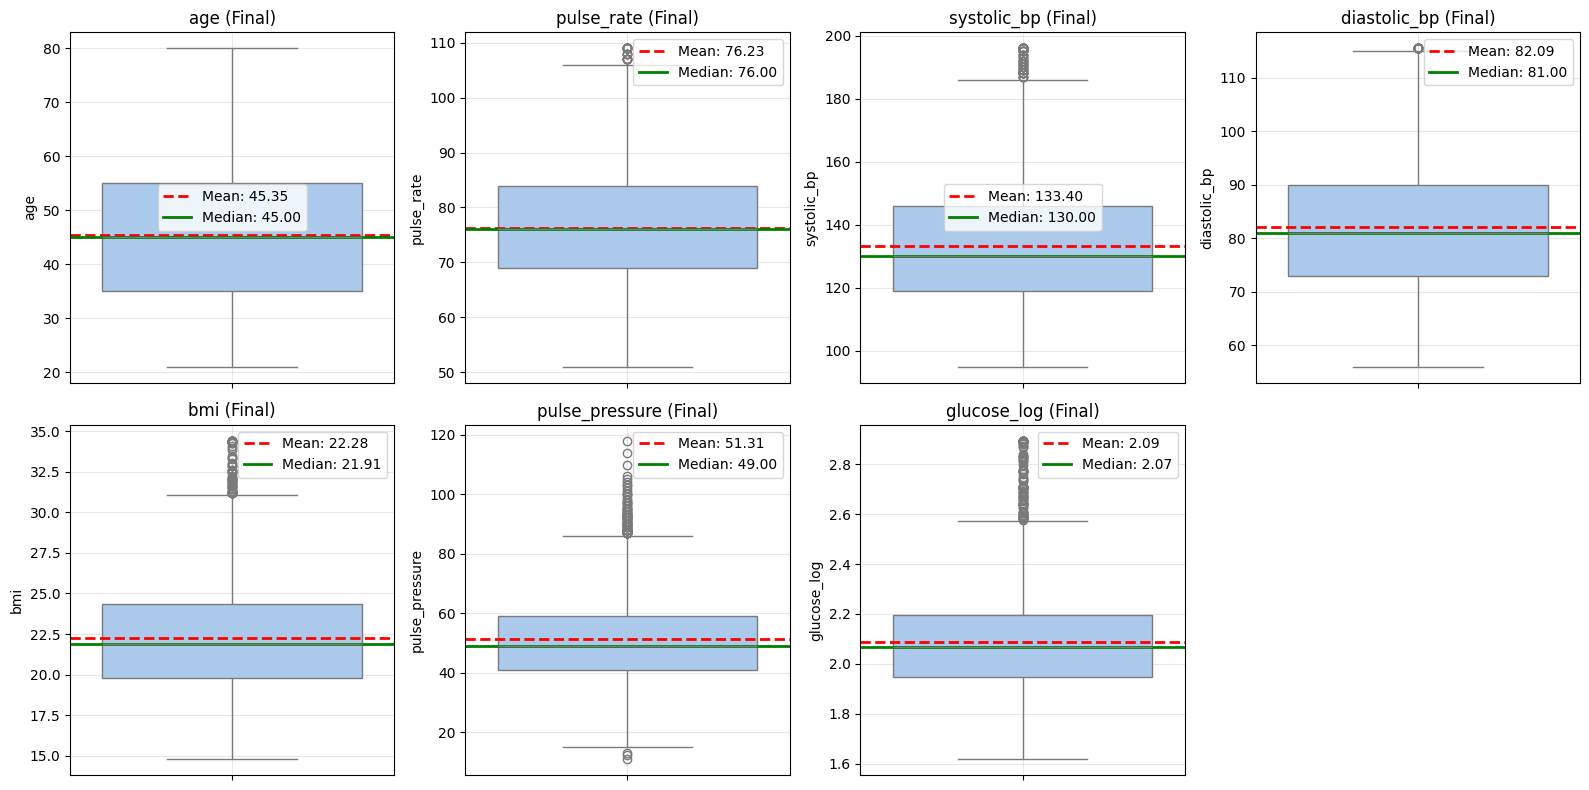

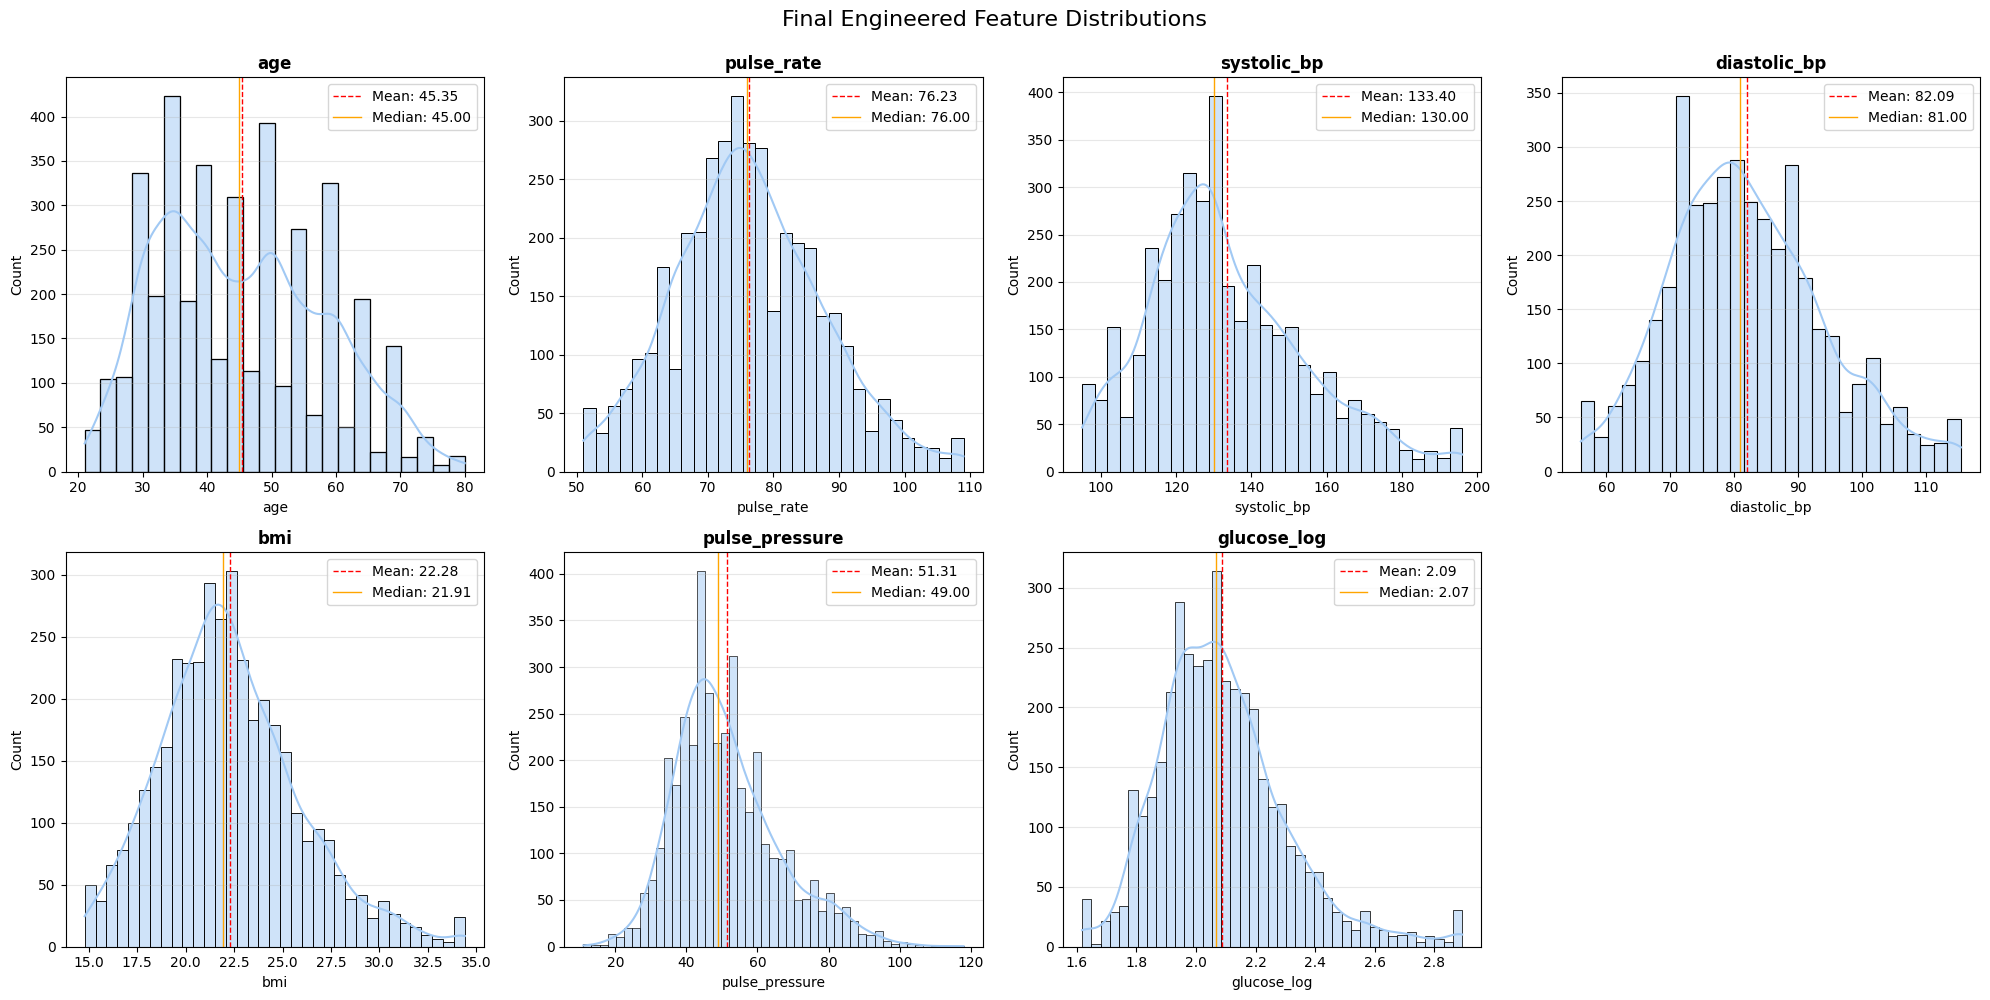

In [ ]:
# Identify final numerical features (exclude binary flags and one-hot)
final_numerical = X_train_clean.select_dtypes(include=[np.number]).columns.tolist()
binary_features = ['hypertension_flag', 'obesity_flag', 'gender']
final_numerical = [col for col in final_numerical if col not in binary_features and 'bmi_' not in col]

print("📊 VISUALIZATION BLOCK: Final Engineered Features")
print(f"   - Numerical features: {final_numerical}")

# Boxplots
print("\n📈 Final Feature Boxplots:")
plot_boxplots(X_train_clean, final_numerical, "(Final)")

# Histograms
n_cols = len(final_numerical)
fig, axes = plt.subplots(2, (n_cols+1)//2, figsize=(5*(n_cols+1)//2, 10))
if n_cols <= 3:
    axes = axes.flatten()[:n_cols]
else:
    axes = axes.flatten()

for idx, feature in enumerate(final_numerical):
    sns.histplot(data=X_train_clean, x=feature, kde=True, ax=axes[idx])

    mean_val = X_train_clean[feature].mean()
    median_val = X_train_clean[feature].median()

    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1,
                      label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='orange', linestyle='-', linewidth=1,
                      label=f'Median: {median_val:.2f}')

    axes[idx].set_title(f'{feature}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(len(final_numerical), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Final Engineered Feature Distributions', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

## Correlation Analysis

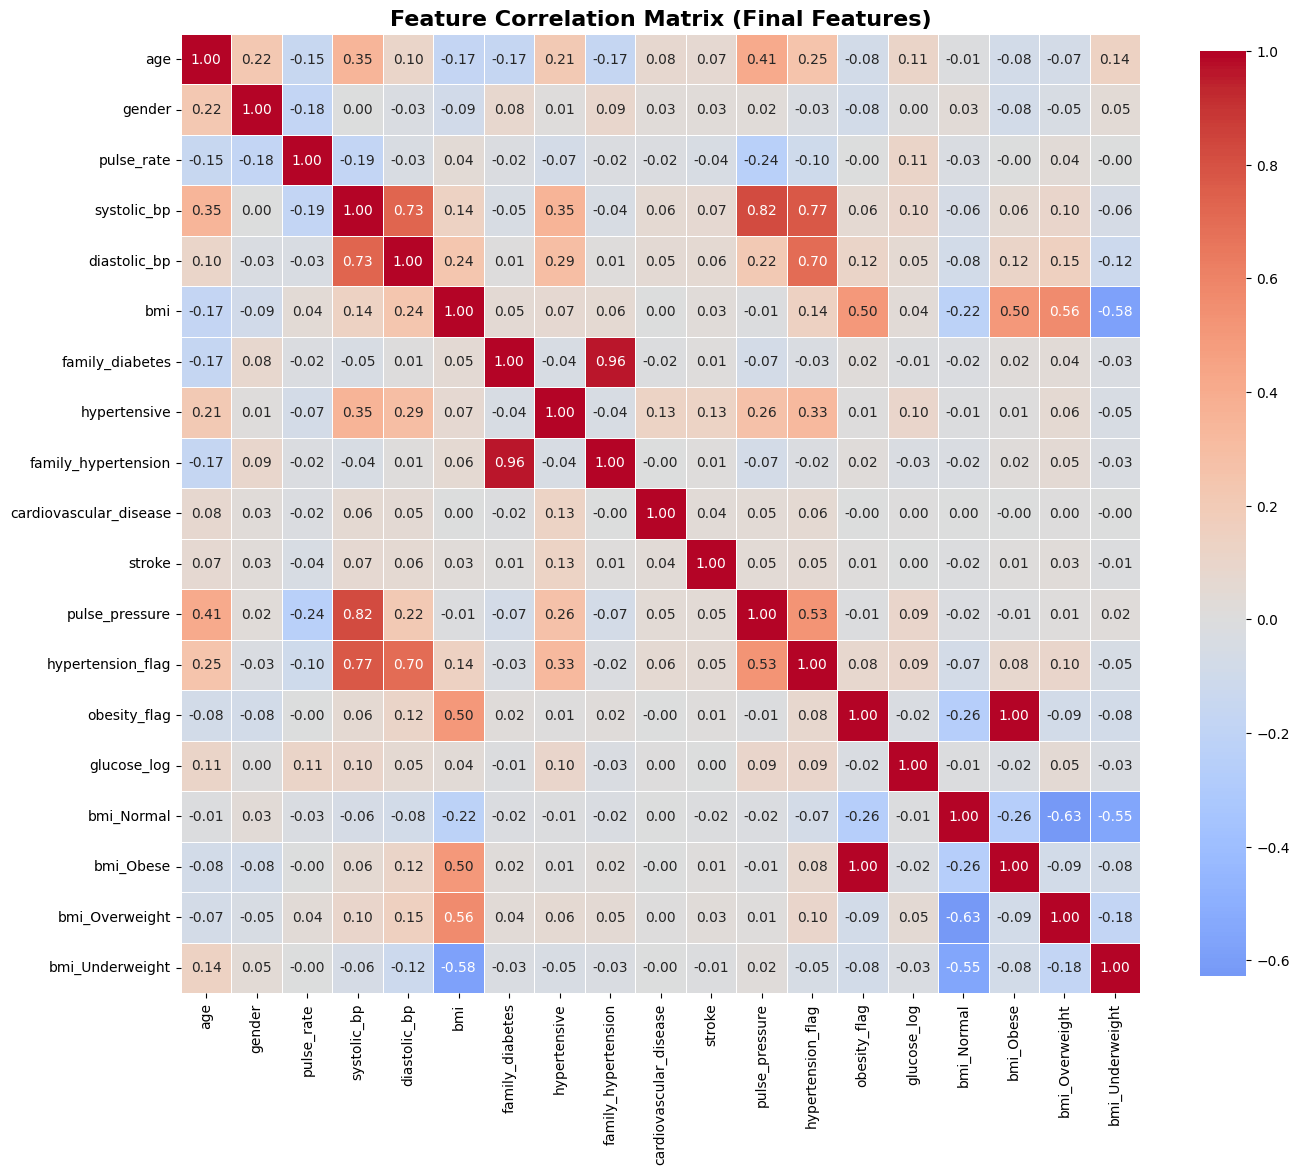

🔍 High Correlation Check (>0.85):
      Feature 1           Feature 2  Correlation
family_diabetes family_hypertension     0.957941
   obesity_flag           bmi_Obese     1.000000

🎯 Feature-Target Correlations:
hypertensive              0.354
glucose_log               0.214
systolic_bp               0.162
diastolic_bp              0.159
hypertension_flag         0.148
bmi                       0.100
pulse_pressure            0.100
age                       0.097
cardiovascular_disease    0.078
bmi_Overweight            0.077
bmi_Underweight          -0.064
stroke                    0.041
gender                    0.032
family_diabetes          -0.024
bmi_Obese                 0.024
obesity_flag              0.024
bmi_Normal               -0.023
pulse_rate                0.020
family_hypertension      -0.014
Name: diabetic, dtype: float64


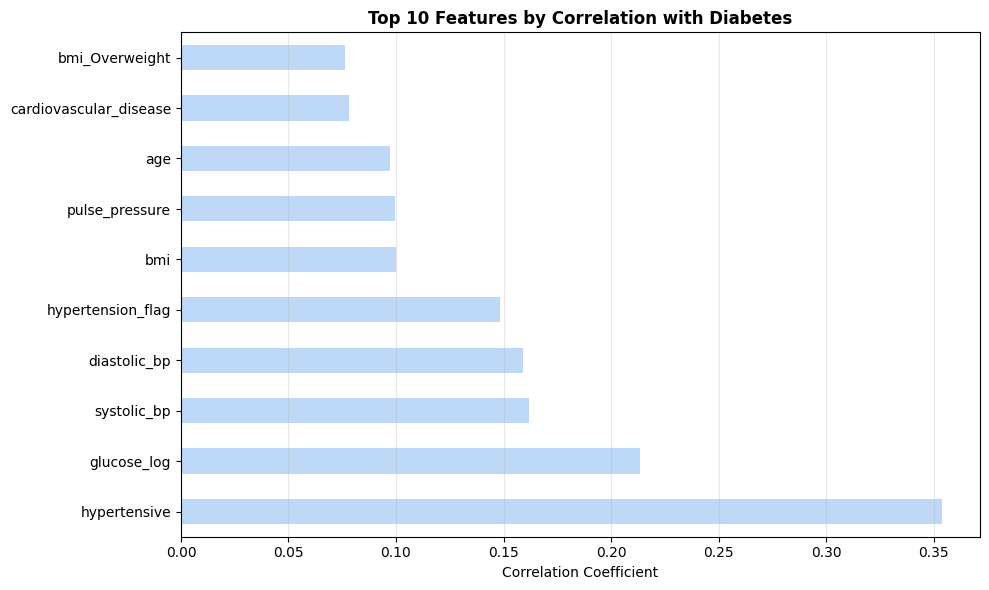

In [ ]:
# Calculate correlation matrix
correlation_matrix = X_train_clean.corr()

fig, ax = plt.subplots(figsize=(14, 12))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.9}, fmt='.2f')

plt.title('Feature Correlation Matrix (Final Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Check for high correlations (>0.85)
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.85:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

print("🔍 High Correlation Check (>0.85):")
if high_corr:
    high_corr_df = pd.DataFrame(high_corr)
    print(high_corr_df.to_string(index=False))
else:
    print("   ✅ No correlations > 0.85 found (good multicollinearity control)")

# Feature-target correlations
print("\n🎯 Feature-Target Correlations:")
# Create temp dataframe with target
temp_df = X_train_clean.copy()
temp_df['diabetic'] = y_train_clean.values

target_correlations = temp_df.corr()['diabetic'].drop('diabetic').sort_values(key=abs, ascending=False)
print(target_correlations.round(3))

# Plot top 10 correlations
top_10 = target_correlations.head(10)
fig, ax = plt.subplots(figsize=(10, 6))
top_10.plot(kind='barh', ax=ax, alpha=0.7)
ax.set_title('Top 10 Features by Correlation with Diabetes', fontweight='bold')
ax.set_xlabel('Correlation Coefficient')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

🔧 CORRELATION-BASED CLEANUP
1️⃣ Removing Perfect Redundancy:
   - obesity_flag is perfectly correlated (1.0) with bmi_Obese
   - Keeping BMI categories (more granular) and dropping obesity_flag
   ✅ obesity_flag removed successfully

📊 Updated Correlation Matrix (After Cleanup):
   ⚠️  High correlations remaining:
      Feature 1           Feature 2  Correlation
family_diabetes family_hypertension     0.957941


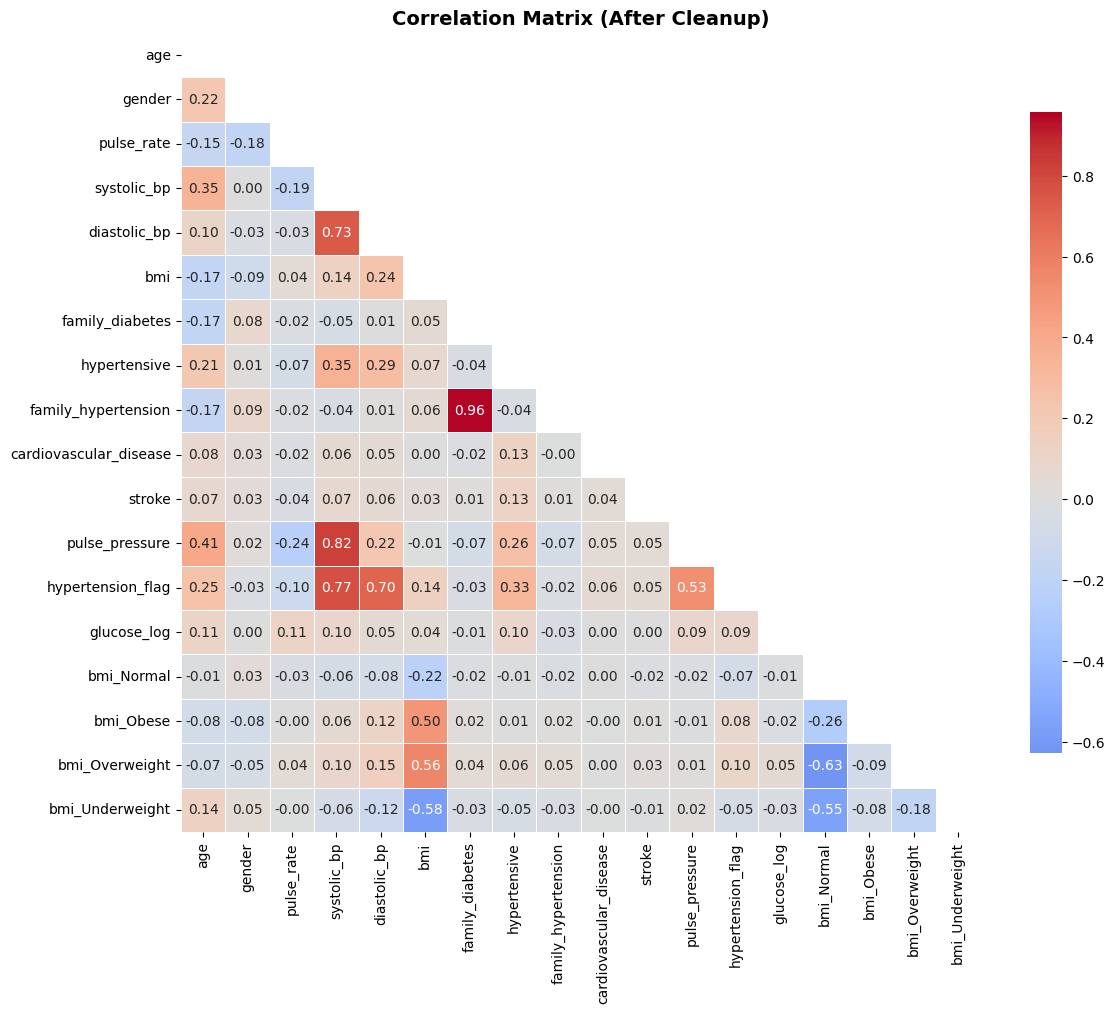


📊 Final Dataset Shapes After Cleanup:
   - X_train_clean: (3939, 18)
   - X_test_final: (1058, 18)


In [ ]:
print("🔧 CORRELATION-BASED CLEANUP")
print("=" * 50)

# Issue 1: Perfect multicollinearity (obesity_flag vs bmi_Obese)
print("1️⃣ Removing Perfect Redundancy:")
print("   - obesity_flag is perfectly correlated (1.0) with bmi_Obese")
print("   - Keeping BMI categories (more granular) and dropping obesity_flag")

# Drop obesity_flag from both train and test
if 'obesity_flag' in X_train_clean.columns:
    X_train_clean.drop(columns=['obesity_flag'], inplace=True)
    X_test.drop(columns=['obesity_flag'], inplace=True)
    print("   ✅ obesity_flag removed successfully")


# Re-calculate correlation matrix after cleanup
print("\n📊 Updated Correlation Matrix (After Cleanup):")
correlation_matrix_clean = X_train_clean.corr()

# Check for any remaining high correlations (>0.85)
high_corr_remaining = []
for i in range(len(correlation_matrix_clean.columns)):
    for j in range(i+1, len(correlation_matrix_clean.columns)):
        corr_val = correlation_matrix_clean.iloc[i, j]
        if abs(corr_val) > 0.85:
            high_corr_remaining.append({
                'Feature 1': correlation_matrix_clean.columns[i],
                'Feature 2': correlation_matrix_clean.columns[j],
                'Correlation': corr_val
            })

if high_corr_remaining:
    print("   ⚠️  High correlations remaining:")
    high_corr_df = pd.DataFrame(high_corr_remaining)
    print(high_corr_df.to_string(index=False))
else:
    print("   ✅ No correlations > 0.85 remaining")

# Visualize updated correlation matrix
mask = np.triu(np.ones_like(correlation_matrix_clean, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(correlation_matrix_clean, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')

plt.title('Correlation Matrix (After Cleanup)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Final Dataset Shapes After Cleanup:")
print(f"   - X_train_clean: {X_train_clean.shape}")
print(f"   - X_test_final: {X_test.shape}")

## Target Imbalance

📊 Training Set Class Distribution:
   - No Diabetes (0): 3732 samples (94.7%)
   - Diabetes (1): 207 samples (5.3%)
   - Imbalance Ratio: 18.03:1


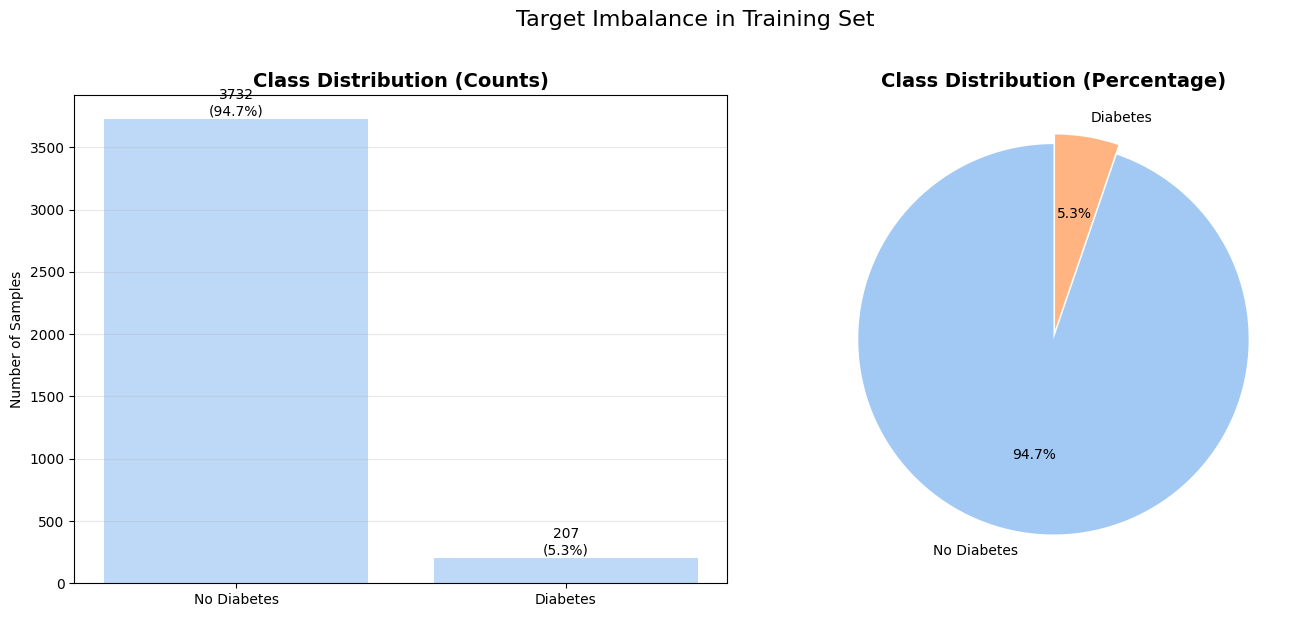

In [ ]:
# Calculate class distribution
class_counts = y_train_clean.value_counts().sort_index()
class_percentages = (class_counts / len(y_train_clean) * 100).round(1)

print("📊 Training Set Class Distribution:")
print(f"   - No Diabetes (0): {class_counts[0]} samples ({class_percentages[0]}%)")
print(f"   - Diabetes (1): {class_counts[1]} samples ({class_percentages[1]}%)")
print(f"   - Imbalance Ratio: {class_counts[0] / class_counts[1]:.2f}:1")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
bars = axes[0].bar(['No Diabetes', 'Diabetes'], class_counts.values, alpha=0.7)
axes[0].set_title('Class Distribution (Counts)', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', alpha=0.3)

# Add percentages
for bar, pct in zip(bars, class_percentages):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}\n({pct}%)', ha='center', va='bottom')

# Pie chart
axes[1].pie(class_counts.values, labels=['No Diabetes', 'Diabetes'],
            autopct='%1.1f%%', startangle=90, explode=(0, 0.05))
axes[1].set_title('Class Distribution (Percentage)', fontweight='bold', fontsize=14)

plt.suptitle('Target Imbalance in Training Set', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Safe Imbalance Handling (No SMOTE)

In [ ]:
# Calculate class distribution
class_counts = y_train_clean.value_counts().sort_index()
class_percentages = (class_counts / len(y_train_clean) * 100).round(1)

print("📊 Training Set Class Distribution:")
print(f"   - No Diabetes (0): {class_counts[0]} samples ({class_percentages[0]}%)")
print(f"   - Diabetes (1): {class_counts[1]} samples ({class_percentages[1]}%)")
print(f"   - Imbalance Ratio: {class_counts[0] / class_counts[1]:.2f}:1")

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_clean.values
)

class_weight_dict = {0: weights[0], 1: weights[1]}

print("\n✅ USING: class_weight='balanced'")
print(f"   - Class 0 weight: {class_weight_dict[0]:.3f}")
print(f"   - Class 1 weight: {class_weight_dict[1]:.3f}")
print("   - This tells models: 'Diabetes samples are 18x more important'")

📊 Training Set Class Distribution:
   - No Diabetes (0): 3732 samples (94.7%)
   - Diabetes (1): 207 samples (5.3%)
   - Imbalance Ratio: 18.03:1

✅ USING: class_weight='balanced'
   - Class 0 weight: 0.528
   - Class 1 weight: 9.514
   - This tells models: 'Diabetes samples are 18x more important'


## Scale & Train

In [ ]:
print("🚀 Phase: Scaling & Baseline Modeling (No SMOTE)")
print("=" * 60)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

# Train models with class_weight='balanced'
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_SEED,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_SEED,
        max_iter=1000,
        class_weight='balanced'
    )
}

results = []

for name, model in models.items():
    print(f"\n📈 {name}:")
    model.fit(X_train_scaled, y_train_clean)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test_encoded, y_pred_proba)
    results.append({'Model': name, 'AUC-ROC': auc})
    print(f"   - AUC-ROC: {auc:.4f}")

print(f"\n📊 Final Results:")
print(pd.DataFrame(results).to_string(index=False))
print("\n✅ Pipeline complete - ready for hyperparameter tuning!")

🚀 Phase: Scaling & Baseline Modeling (No SMOTE)

📈 Random Forest:
   - AUC-ROC: 0.8360

📈 Logistic Regression:
   - AUC-ROC: 0.8183

📊 Final Results:
              Model  AUC-ROC
      Random Forest 0.835985
Logistic Regression 0.818301

✅ Pipeline complete - ready for hyperparameter tuning!


## GPU Check & Setup

In [ ]:
print("🔧 GPU Setup Check")
print("=" * 50)

# Check GPU availability in Colab
gpu_info = !nvidia-smi --query-gpu=name,memory.total,memory.used --format=csv,noheader,nounits
# Add a check for the length of the split array to ensure the expected format
if gpu_info and len(gpu_info[0].split(',')) == 3:
    print("✅ GPU DETECTED in Colab:")
    gpu_name, gpu_mem_total, gpu_mem_used = gpu_info[0].split(',')
    print(f"   - GPU: {gpu_name.strip()}")
    print(f"   - Memory: {gpu_mem_used.strip()}MB / {gpu_mem_total.strip()}MB")
    GPU_AVAILABLE = True
else:
    print("❌ No GPU detected or invalid nvidia-smi output - using CPU (slower but functional)")
    GPU_AVAILABLE = False

# Configure XGBoost for GPU if available
if GPU_AVAILABLE:
    print("\n🎯 Configuring XGBoost for GPU...")
    xgb_tree_method = 'gpu_hist'
    xgb_predictor = 'gpu_predictor'
    print(f"   - XGBoost tree_method: {xgb_tree_method}")
    print("   - This will significantly speed up tuning")
else:
    xgb_tree_method = 'hist'  # Fast CPU method
    xgb_predictor = 'cpu_predictor'
    print(f"\n🎯 XGBoost tree_method: {xgb_tree_method} (CPU)")

# Performance note
print("\n📊 Performance Expectations:")
print("   - XGBoost with GPU: ~5-10x faster")
print("   - Random Forest/Logistic: CPU only (sklearn limitation)")
print("   - SHAP analysis: GPU accelerates XGBoost explanations")

🔧 GPU Setup Check
❌ No GPU detected or invalid nvidia-smi output - using CPU (slower but functional)

🎯 XGBoost tree_method: hist (CPU)

📊 Performance Expectations:
   - XGBoost with GPU: ~5-10x faster
   - Random Forest/Logistic: CPU only (sklearn limitation)
   - SHAP analysis: GPU accelerates XGBoost explanations


## Hyperparameter Tuning

### Setup Scaler, CV, and Imbalance Parameters

In [ ]:
print("🔧 SETUP: Scaler, Cross-Validation & Imbalance Parameters")
print("=" * 65)

# 1. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test)

# 2. Save the scaler for future use
joblib.dump(scaler, '/content/scaler.pkl')
print("✅ Scaler saved as '/content/scaler.pkl'")

# 3. Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scoring = make_scorer(roc_auc_score)

# 4. Calculate imbalance ratio for XGBoost
class_counts = y_train_clean.value_counts().sort_index()
scale_pos_weight = class_counts[0] / class_counts[1]  # For XGBoost

print(f"📊 Setup Summary:")
print(f"   - Training data scaled: {X_train_scaled.shape}")
print(f"   - Test data scaled: {X_test_scaled.shape}")
print(f"   - Cross-validation: {cv.n_splits}-fold stratified")
print(f"   - XGBoost scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   - Scoring metric: ROC-AUC")

print("🚀 Ready for individual model tuning blocks!")

🔧 SETUP: Scaler, Cross-Validation & Imbalance Parameters
✅ Scaler saved as '/content/scaler.pkl'
📊 Setup Summary:
   - Training data scaled: (3939, 18)
   - Test data scaled: (1058, 18)
   - Cross-validation: 5-fold stratified
   - XGBoost scale_pos_weight: 18.03
   - Scoring metric: ROC-AUC
🚀 Ready for individual model tuning blocks!


### Random Forest Tuning

🎯 TUNING RANDOM FOREST (Individual Block)


Random Forest: 100%|████████████████████████████████████████████████| 30/30 [04:27<00:00,  8.92s/it]



✅ Best CV Score: 0.7706
📋 Best Params: {'n_estimators': 230, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': None}
💾 Saved: Random_Forest_best.pkl

🔝 Top 10 Features:
        feature  importance
   hypertensive    0.491440
    glucose_log    0.210983
            bmi    0.100012
   diastolic_bp    0.066873
            age    0.038008
    systolic_bp    0.033745
 pulse_pressure    0.023753
     pulse_rate    0.022812
         gender    0.006993
family_diabetes    0.001689


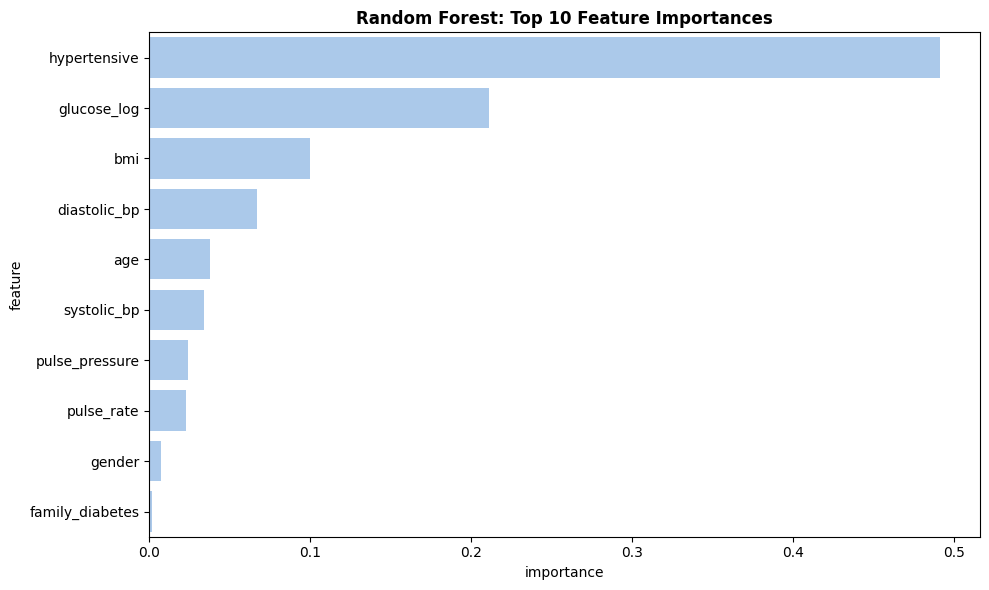


🏁 Random Forest tuning complete!


In [ ]:
print("🎯 TUNING RANDOM FOREST (Individual Block)")
print("=" * 55)

# Assume cv, scoring, X_train_scaled, y_train_clean are defined from previous blocks

# Random Forest parameter grid
rf_params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 21),
    'min_samples_split': randint(2, 21),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2', None]
}

# Fixed parameters
rf_fixed = {'class_weight': 'balanced', 'n_jobs': -1, 'random_state': RANDOM_SEED}

# Tuning loop
best_rf_score = 0
best_rf_params = None

for i in tqdm(range(30), desc="Random Forest", ncols=100):
    # Sample random parameters
    params = {k: (v.rvs() if hasattr(v, 'rvs') else np.random.choice(v))
              for k, v in rf_params.items()}

    model = RandomForestClassifier(**rf_fixed, **params)
    scores = cross_val_score(model, X_train_scaled, y_train_clean,
                            cv=cv, scoring=scoring, n_jobs=-1)

    mean_score = scores.mean()
    if mean_score > best_rf_score:
        best_rf_score = mean_score
        best_rf_params = params

# Train final model
print(f"\n✅ Best CV Score: {best_rf_score:.4f}")
print(f"📋 Best Params: {best_rf_params}")

rf_final = RandomForestClassifier(**rf_fixed, **best_rf_params)
rf_final.fit(X_train_scaled, y_train_clean)

# Save model
joblib.dump(rf_final, '/content/Random_Forest_best.pkl')
print("💾 Saved: Random_Forest_best.pkl")

# Feature importance
importance = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\n🔝 Top 10 Features:")
print(importance.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature', ax=ax)
ax.set_title('Random Forest: Top 10 Feature Importances', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🏁 Random Forest tuning complete!")

## Logistic Regression Tuning

In [ ]:
print("🎯 TUNING LOGISTIC REGRESSION (Individual Block)")
print("=" * 55)

# Logistic Regression parameter grid
lr_params = {
    'C': uniform(0.001, 10),
    'penalty': ['l1', 'l2']
}

# Fixed parameters
lr_fixed = {
    'class_weight': 'balanced',
    'max_iter': 1000,
    'solver': 'liblinear',
    'random_state': RANDOM_SEED
}

# Tuning loop
best_lr_score = 0
best_lr_params = None

for i in tqdm(range(30), desc="Logistic Regression", ncols=100):
    params = {k: (v.rvs() if hasattr(v, 'rvs') else np.random.choice(v))
              for k, v in lr_params.items()}

    model = LogisticRegression(**lr_fixed, **params)
    scores = cross_val_score(model, X_train_scaled, y_train_clean,
                            cv=cv, scoring=scoring, n_jobs=-1)

    mean_score = scores.mean()
    if mean_score > best_lr_score:
        best_lr_score = mean_score
        best_lr_params = params

# Train final model
print(f"\n✅ Best CV Score: {best_lr_score:.4f}")
print(f"📋 Best Params: {best_lr_params}")

lr_final = LogisticRegression(**lr_fixed, **best_lr_params)
lr_final.fit(X_train_scaled, y_train_clean)

# Save model
joblib.dump(lr_final, '/content/Logistic_Regression_best.pkl')
print("💾 Saved: Logistic_Regression_best.pkl")

print("\n🏁 Logistic Regression tuning complete!")

🎯 TUNING LOGISTIC REGRESSION (Individual Block)


Logistic Regression: 100%|██████████████████████████████████████████| 30/30 [00:11<00:00,  2.73it/s]


✅ Best CV Score: 0.7865
📋 Best Params: {'C': np.float64(0.006203769953158188), 'penalty': np.str_('l1')}
💾 Saved: Logistic_Regression_best.pkl

🏁 Logistic Regression tuning complete!


### XGBoost Tuning

🎯 TUNING XGBOOST (Individual Block)


XGBoost: 100%|██████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]



✅ Best CV Score: 0.7836
📋 Best Params: {'n_estimators': 101, 'max_depth': 3, 'learning_rate': np.float64(0.037930830341769764), 'subsample': np.float64(0.9588863031813307), 'colsample_bytree': np.float64(0.9601672228653322), 'min_child_weight': 7, 'gamma': np.float64(0.16951489552435034), 'tree_method': np.str_('hist')}
💾 Saved: XGBoost_best.pkl

🔝 Top 10 Features:
               feature  importance
          hypertensive    0.402276
           systolic_bp    0.076312
          diastolic_bp    0.075450
           glucose_log    0.074390
     hypertension_flag    0.073463
cardiovascular_disease    0.061750
       bmi_Underweight    0.061120
                   bmi    0.052694
                gender    0.039659
                   age    0.039131


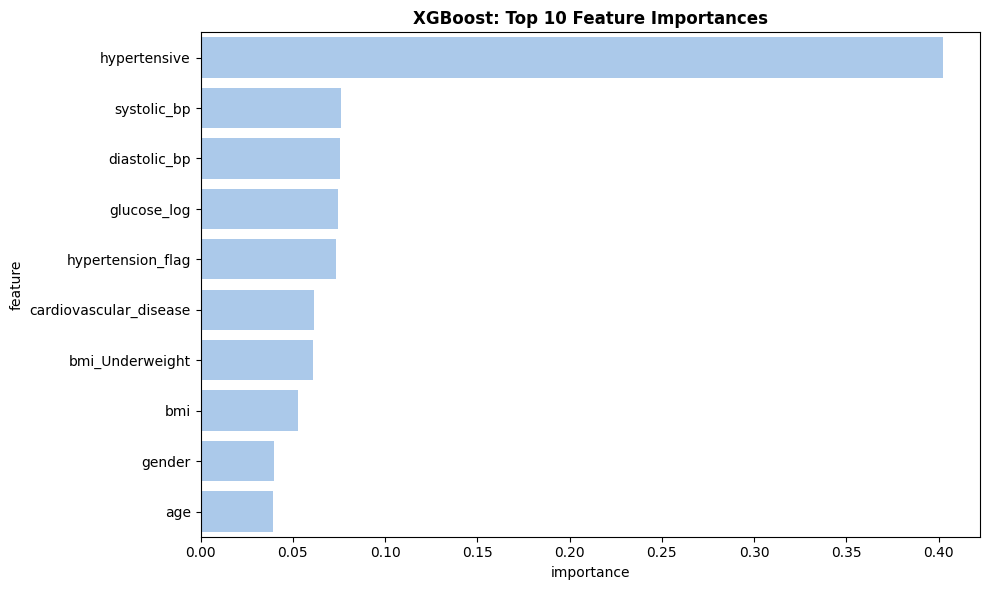


🏁 XGBoost tuning complete!


In [ ]:
print("🎯 TUNING XGBOOST (Individual Block)")
print("=" * 55)

# XGBoost parameter grid
xgb_params = {
    'n_estimators': randint(100, 301),
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 11),
    'gamma': uniform(0, 0.5),
    'tree_method': ['hist']
}

# Fixed parameters
xgb_fixed = {
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss',
    'device': 'cuda' if GPU_AVAILABLE else 'cpu',
    'random_state': RANDOM_SEED
}

# Tuning loop
best_xgb_score = 0
best_xgb_params = None

for i in tqdm(range(30), desc="XGBoost", ncols=100):
    params = {k: (v.rvs() if hasattr(v, 'rvs') else np.random.choice(v))
              for k, v in xgb_params.items()}

    model = xgb.XGBClassifier(**xgb_fixed, **params)
    scores = cross_val_score(model, X_train_scaled, y_train_clean,
                            cv=cv, scoring=scoring, n_jobs=-1)

    mean_score = scores.mean()
    if mean_score > best_xgb_score:
        best_xgb_score = mean_score
        best_xgb_params = params

# Train final model
print(f"\n✅ Best CV Score: {best_xgb_score:.4f}")
print(f"📋 Best Params: {best_xgb_params}")

xgb_final = xgb.XGBClassifier(**xgb_fixed, **best_xgb_params)
xgb_final.fit(X_train_scaled, y_train_clean)

# Save model
joblib.dump(xgb_final, '/content/XGBoost_best.pkl')
print("💾 Saved: XGBoost_best.pkl")

# Feature importance
importance = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\n🔝 Top 10 Features:")
print(importance.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature', ax=ax)
ax.set_title('XGBoost: Top 10 Feature Importances', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🏁 XGBoost tuning complete!")

## Final Test Evaluation (Load & Score)

In [ ]:
print("🎯 FINAL TEST SET EVALUATION")
print("=" * 70)
print("📂 Loading saved models and making predictions...")
print("")

# Load scaler
scaler = joblib.load('/content/scaler.pkl')
X_test_scaled = scaler.transform(X_test)

# Define models to evaluate
model_files = {
    'Random Forest': '/content/Random_Forest_best.pkl',
    'Logistic Regression': '/content/Logistic_Regression_best.pkl',
    'XGBoost': '/content/XGBoost_best.pkl'
}

# Results storage
final_results = []

# Evaluate each model
for model_name, model_path in model_files.items():
    print(f"📊 Evaluating {model_name}...")

    try:
        # Load model
        model = joblib.load(model_path)

        # Make predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        auc = roc_auc_score(y_test_encoded, y_pred_proba)
        accuracy = (y_pred == y_test_encoded).mean()

        # Diabetes class metrics (the minority class)
        tp = ((y_pred == 1) & (y_test_encoded == 1)).sum()
        fp = ((y_pred == 1) & (y_test_encoded == 0)).sum()
        fn = ((y_pred == 0) & (y_test_encoded == 1)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Store results
        final_results.append({
            'Model': model_name,
            'AUC-ROC': auc,
            'Accuracy': accuracy,
            'Diabetes Precision': precision,
            'Diabetes Recall': recall
        })

        print(f"   ✅ AUC-ROC: {auc:.4f}")
        print(f"   - Accuracy: {accuracy:.4f}")
        print(f"   - Diabetes Precision: {precision:.4f}")
        print(f"   - Diabetes Recall: {recall:.4f}")

        # Classification report
        print("\n   📋 Classification Report:")
        print(classification_report(y_test_encoded, y_pred,
                                  target_names=['No Diabetes', 'Diabetes'],
                                  digits=4))

        # Confusion matrix
        cm = confusion_matrix(y_test_encoded, y_pred)
        print("   🎯 Confusion Matrix:")
        print(f"   True Negatives:  {cm[0,0]}")
        print(f"   False Positives: {cm[0,1]}")
        print(f"   False Negatives: {cm[1,0]}")
        print(f"   True Positives:  {cm[1,1]}")
        print("-" * 60)

        # Save predictions for downstream analysis
        predictions_df = pd.DataFrame({
            'true_label': y_test_encoded.values,
            'predicted_label': y_pred,
            'predicted_probability': y_pred_proba
        })
        predictions_df.to_csv(f'/content/{model_name.replace(" ", "_")}_predictions.csv', index=False)
        print(f"   💾 Saved predictions to {model_name.replace(' ', '_')}_predictions.csv\n")

    except FileNotFoundError:
        print(f"   ❌ Model file not found: {model_path}")
        print(f"   - Please run the tuning block for {model_name} first")
    except Exception as e:
        print(f"   ❌ Error: {e}")

# Summary comparison table
print("📈 FINAL MODEL COMPARISON SUMMARY:")
summary_df = pd.DataFrame(final_results).sort_values('AUC-ROC', ascending=False)
print(summary_df.to_string(index=False, float_format='%.4f'))

# Best model highlight
if not summary_df.empty:
    best_model_name = summary_df.iloc[0]['Model']
    best_auc = summary_df.iloc[0]['AUC-ROC']
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   - Test AUC-ROC: {best_auc:.4f}")
    print("   ✅ All models evaluated and saved!")

🎯 FINAL TEST SET EVALUATION
📂 Loading saved models and making predictions...

📊 Evaluating Random Forest...
   ✅ AUC-ROC: 0.8463
   - Accuracy: 0.8639
   - Diabetes Precision: 0.2625
   - Diabetes Recall: 0.6176

   📋 Classification Report:
              precision    recall  f1-score   support

 No Diabetes     0.9710    0.8808    0.9237       990
    Diabetes     0.2625    0.6176    0.3684        68

    accuracy                         0.8639      1058
   macro avg     0.6168    0.7492    0.6461      1058
weighted avg     0.9255    0.8639    0.8880      1058

   🎯 Confusion Matrix:
   True Negatives:  872
   False Positives: 118
   False Negatives: 26
   True Positives:  42
------------------------------------------------------------
   💾 Saved predictions to Random_Forest_predictions.csv

📊 Evaluating Logistic Regression...
   ✅ AUC-ROC: 0.8123
   - Accuracy: 0.8261
   - Diabetes Precision: 0.2157
   - Diabetes Recall: 0.6471

   📋 Classification Report:
              precision    r

## Testing


In [ ]:
# =============================================================================
# 🔧 SAVE TEST DATA FOR INFERENCE DEMO (AFTER ALL FEATURE ENGINEERING)
# =============================================================================

print("💾 SAVING FINAL PROCESSED TEST DATA FOR INFERENCE...")

# Use the FINAL processed X_test and y_test_encoded (after all transformations)
test_data_final = X_test.copy()
test_data_final['diabetic'] = y_test_encoded.values  # Use the encoded target

print(f"📊 Final test data shape: {test_data_final.shape}")
print(f"📋 Final features: {test_data_final.columns.tolist()}")

# Save the FINAL processed test data
test_data_final.to_csv('/content/test_data_final.csv', index=False)
print("✅ Final processed test data saved: 'test_data_final.csv'")

# Save a small sample for quick demo (using the FINAL features)
test_sample_final = X_test.head(5).copy()
test_sample_final['diabetic'] = y_test_encoded.head(5).values
test_sample_final.to_csv('/content/test_sample_final.csv', index=False)
print("✅ Final test sample saved: 'test_sample_final.csv'")

# Verify feature alignment
print("\n🔍 FEATURE VERIFICATION:")
print(f"   - X_train_clean features: {X_train_clean.columns.tolist()}")
print(f"   - X_test features: {X_test.columns.tolist()}")
print(f"   - Feature match: {list(X_train_clean.columns) == list(X_test.columns)}")

print("🎯 Test data ready for inference.py!")

💾 SAVING FINAL PROCESSED TEST DATA FOR INFERENCE...
📊 Final test data shape: (1058, 19)
📋 Final features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'glucose_log', 'bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight', 'diabetic']
✅ Final processed test data saved: 'test_data_final.csv'
✅ Final test sample saved: 'test_sample_final.csv'

🔍 FEATURE VERIFICATION:
   - X_train_clean features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'glucose_log', 'bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']
   - X_test features: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardi

In [ ]:
# inference.py
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def run_demo():
    print("🚀 ML PROJECT - MODEL INFERENCE DEMO")
    print("=" * 50)

    try:
        # Load the FINAL processed test data
        print("📂 Loading FINAL processed test data...")
        test_data = pd.read_csv('test_data_final.csv')
        X_test = test_data.drop(columns=['diabetic'])
        y_test = test_data['diabetic']

        print(f"   - Test samples: {X_test.shape[0]}")
        print(f"   - Features: {X_test.shape[1]}")
        print(f"   - Feature names: {list(X_test.columns)}")

        # Load models
        print("📂 Loading models...")
        scaler = joblib.load('scaler.pkl')
        models = {
            'Logistic Regression': joblib.load('Logistic_Regression_best.pkl'),
            'Random Forest': joblib.load('Random_Forest_best.pkl'),
            'XGBoost': joblib.load('XGBoost_best.pkl')
        }

        print("✅ All models loaded successfully!")

        # Scale the test data (using the same scaler from training)
        X_test_scaled = scaler.transform(X_test)

        print("\n🎯 MODEL PERFORMANCE ON TEST SET:")
        print("=" * 50)

        results = []
        for name, model in models.items():
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

            # Calculate metrics
            auc = roc_auc_score(y_test, y_pred_proba)
            accuracy = (y_pred == y_test).mean()

            # Store results
            results.append({
                'Model': name,
                'AUC-ROC': auc,
                'Accuracy': accuracy
            })

            print(f"\n📊 {name}:")
            print(f"   - AUC-ROC: {auc:.4f}")
            print(f"   - Accuracy: {accuracy:.4f}")

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            print(f"   - Confusion Matrix: TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")

        # Show comparison table
        print("\n" + "=" * 50)
        print("📈 MODEL COMPARISON SUMMARY")
        print("=" * 50)

        results_df = pd.DataFrame(results).sort_values('AUC-ROC', ascending=False)
        print(results_df.to_string(index=False, float_format='%.4f'))

        # Best model
        best_model_info = results_df.iloc[0]
        best_model_name = best_model_info['Model']
        best_auc = best_model_info['AUC-ROC']

        print(f"\n🏆 BEST MODEL: {best_model_name}")
        print(f"   - Test AUC-ROC: {best_auc:.4f}")

        # Quick demo with sample data
        print("\n" + "=" * 50)
        print("🔍 SINGLE SAMPLE PREDICTION DEMO")
        print("=" * 50)

        sample_data = pd.read_csv('test_sample_final.csv')
        X_sample = sample_data.drop(columns=['diabetic'])
        y_sample = sample_data['diabetic']
        X_sample_scaled = scaler.transform(X_sample)

        best_model = models[best_model_name]

        print(f"Using {best_model_name} for predictions:\n")

        for i in range(len(X_sample)):
            # Get prediction
            prediction = best_model.predict(X_sample_scaled[i:i+1])[0]
            probability = best_model.predict_proba(X_sample_scaled[i:i+1])[0]

            # Convert to readable labels
            actual_label = "Diabetes" if y_sample.iloc[i] == 1 else "No Diabetes"
            predicted_label = "Diabetes" if prediction == 1 else "No Diabetes"
            prob_diabetes = probability[1]

            # Check if correct
            is_correct = "✅ CORRECT" if prediction == y_sample.iloc[i] else "❌ WRONG"

            print(f"Sample {i+1}:")
            print(f"   Actual: {actual_label}")
            print(f"   Predicted: {predicted_label} (probability: {prob_diabetes:.3f})")
            print(f"   Result: {is_correct}")
            print()

    except Exception as e:
        print(f"❌ Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    run_demo()

🚀 ML PROJECT - MODEL INFERENCE DEMO
📂 Loading FINAL processed test data...
   - Test samples: 1058
   - Features: 18
   - Feature names: ['age', 'gender', 'pulse_rate', 'systolic_bp', 'diastolic_bp', 'bmi', 'family_diabetes', 'hypertensive', 'family_hypertension', 'cardiovascular_disease', 'stroke', 'pulse_pressure', 'hypertension_flag', 'glucose_log', 'bmi_Normal', 'bmi_Obese', 'bmi_Overweight', 'bmi_Underweight']
📂 Loading models...
✅ All models loaded successfully!

🎯 MODEL PERFORMANCE ON TEST SET:

📊 Logistic Regression:
   - AUC-ROC: 0.8123
   - Accuracy: 0.8261
   - Confusion Matrix: TN=830, FP=160, FN=24, TP=44

📊 Random Forest:
   - AUC-ROC: 0.8463
   - Accuracy: 0.8639
   - Confusion Matrix: TN=872, FP=118, FN=26, TP=42

📊 XGBoost:
   - AUC-ROC: 0.8472
   - Accuracy: 0.8422
   - Confusion Matrix: TN=844, FP=146, FN=21, TP=47

📈 MODEL COMPARISON SUMMARY
              Model  AUC-ROC  Accuracy
            XGBoost   0.8472    0.8422
      Random Forest   0.8463    0.8639
Logistic 